In [1]:
#The goal is to predict Leq (noise level in dBA) using inputs like vehicle capacity (PCU), speed, flow type

In [2]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt  
import seaborn as sns

# Set seeds for all relevant libraries
random.seed(42)  # Python's built-in random
np.random.seed(42)  # NumPy
torch.manual_seed(42)  # PyTorch (affects weight init and shuffling)
torch.cuda.manual_seed_all(42)  # If using GPU, seed all GPUs
torch.backends.cudnn.deterministic = True  # Make CUDA ops deterministic
torch.backends.cudnn.benchmark = False

In [3]:
# Load sheets
file_path = 'data\\FINAL DATA.xlsx'  # Update to your actual path
df_leq = pd.read_excel(file_path, sheet_name='Noise Leq Data')
df_speed = pd.read_excel(file_path, sheet_name='SPEED')
df_pcu = pd.read_excel(file_path, sheet_name='PCU')
df_pcu_conv = pd.read_excel(file_path, sheet_name='PCU Conversion')  # For vehicle counts

# Modified data processing to extract vehicle categories like the paper
data = []
places = df_leq['Place'].dropna().unique()
hours = ['6-7AM', '7-8AM', '8-9AM', '9-10AM', '10-11AM', '11-12PM', '12-1PM', '1-2PM', '2-3PM', '3-4PM', '4-5PM', '5-6PM']

lanes_dict = {
    'Around Arya School': 2,  # Ngara Arya
    'Around Baba Dogo Rd': 2,
    'Around Junction Mall': 4,
    'Around Langata Hospital': 4,
    'Around MMU': 4,
    'BBS Eastleigh': 4,
    'Bee Centre': 2,
    'Close to Uhuru Park': 2,
    'Davis&Shirtliff Kangundo Rd': 2,
    'ICD Road': 4,
    'Imaara Mall': 4,
    'Jevanjee': 2,
    'Jogoo Road': 4,
    'Kangemi': 4,
    'Karen C School': 2,
    'Kawangware': 2,
    'KCB Utawala Eastern Bypass': 4,
    'KFC Embakasi': 4,
    'Kiambu Road': 2,
    'Kiambu Road 2': 2,
    'Kinoo': 2,
    'Langata Link Road': 4,
    'Likoni Road': 4,
    'Makongeni Shopping Centre Ruai': 2,
    'Ngong Road': 4,
    'Northern Bypass': 2,
    'Nyayo Langata': 4,
    'Ola Energy Waiyaki Way': 8,
    'Opp. KU Hospital': 2,
    'Quality Meat Packers': 2,
    'Raila Odinga Road Next to Total': 4,
    'Ruaka': 2,
    'Runda': 2,
    'Southern Bypass 1': 4,
    'Southern Bypass 2': 4,
    'Thika Road 1': 8,
    'Thika Road 2': 8,
    'Thika Road (Pangani)': 8,
    'Thome': 2,
    'Total Energies Outering': 8,
    'Winners Chapel (Likoni Road)': 4,
    'Junction Mall': 4,
    'Arya (Ngara)': 2,
    'Around Baba Dogo Road': 2
}

for i, place in enumerate(places):
    leq_row = df_leq.iloc[i, 2:].values  # Leq per hour
    speed_row = df_speed.iloc[i, 2:].values  # Speed per hour
    pcu_row = df_pcu.iloc[i, 2:].values  # PCU per hour
    
    # Get vehicle categories from PCU Conversion
    place_conv = df_pcu_conv[df_pcu_conv['Place'].str.strip().str.upper() == place.strip().upper()]
    if not place_conv.empty:
        conv_row = place_conv.iloc[0, 3:].values  # Start from 'Bicycle' column
        vehicle_cols = df_pcu_conv.columns[3:]  # Columns from 'Bicycle' onward
        
        # Extract vehicle counts (handle missing columns with defaults)
        motorcycles = conv_row[list(vehicle_cols).index('Motorcycles')] if 'Motorcycles' in vehicle_cols else 0
        light_cols = ['Private car', 'Pickup', 'SUV']  # Define light vehicle categories
        light_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in light_cols if col in vehicle_cols)
        medium_cols = ['Buses', 'Light trucks']  # Define medium vehicle categories
        medium_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in medium_cols if col in vehicle_cols)
        heavy_cols = ['Medium trucks', 'Heavy trucks']  # Define heavy vehicle categories
        heavy_vehicles = sum(conv_row[list(vehicle_cols).index(col)] for col in heavy_cols if col in vehicle_cols)
        
        # Convert NaN to 0
        motorcycles = 0 if pd.isna(motorcycles) else motorcycles
        light_vehicles = 0 if pd.isna(light_vehicles) else light_vehicles
        medium_vehicles = 0 if pd.isna(medium_vehicles) else medium_vehicles
        heavy_vehicles = 0 if pd.isna(heavy_vehicles) else heavy_vehicles
    else:
        motorcycles = light_vehicles = medium_vehicles = heavy_vehicles = 0
    
    lanes = lanes_dict.get(place, 2)
    
    # Process each hour
    for h, hour in enumerate(hours):
        if pd.notna(leq_row[h]) and pd.notna(speed_row[h]) and pd.notna(pcu_row[h]):
            current_speed = speed_row[h]
            
            # Flow type based on speed (like paper's traffic condition)
            if current_speed < 20:
                flow_type = 0  # Congested
            elif current_speed < 35:
                flow_type = 1  # Periodic
            else:
                flow_type = 2  # Fluid
            
            data.append({
                'place': place,
                'motorcycles': motorcycles,
                'light': light_vehicles,
                'medium': medium_vehicles,
                'heavy': heavy_vehicles,
                'speed': current_speed,
                'lanes': lanes,
                'flow_type': flow_type,
                'leq': leq_row[h]
            })

df = pd.DataFrame(data)
df = df.dropna()
print("New feature set shape:", df.shape)
print("Features:", df.columns.tolist())

New feature set shape: (504, 9)
Features: ['place', 'motorcycles', 'light', 'medium', 'heavy', 'speed', 'lanes', 'flow_type', 'leq']


In [4]:
# NEW: Features exactly like the paper
features = ['motorcycles', 'light', 'medium', 'heavy', 'speed', 'lanes', 'flow_type']  # 7 features like paper
target = 'leq'

X = df[features].values
y = df[target].values

print(f"Input shape: {X.shape}")  # Should be (n_samples, 7)
print(f"Target shape: {y.shape}")

Input shape: (504, 7)
Target shape: (504,)


In [5]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create datasets
train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
test_ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

batch_size = 8
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
class NoisePredictor(nn.Module):
    def __init__(self, input_dim):
        super(NoisePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 25)
        self.fc2 = nn.Linear(25, 50)
        self.fc3 = nn.Linear(50, 1)  # Continuous output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

input_dim = X.shape[1]
model = NoisePredictor(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

NoisePredictor(
  (fc1): Linear(in_features=7, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [7]:
def train_predictor(model, train_dl, num_epochs=10000):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dl), epochs=num_epochs)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_dl:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_dl)
        print(f'Epoch {epoch}: Loss {avg_loss:.2f}')

train_predictor(model, train_dl)

Epoch 0: Loss 5796.66
Epoch 1: Loss 5788.32
Epoch 2: Loss 5788.34
Epoch 3: Loss 5780.63
Epoch 4: Loss 5768.86
Epoch 5: Loss 5773.13
Epoch 6: Loss 5759.75
Epoch 7: Loss 5752.52
Epoch 8: Loss 5754.89
Epoch 9: Loss 5749.30
Epoch 10: Loss 5732.91
Epoch 11: Loss 5722.07
Epoch 12: Loss 5712.43
Epoch 13: Loss 5703.47
Epoch 14: Loss 5696.81
Epoch 15: Loss 5683.23
Epoch 16: Loss 5668.04
Epoch 17: Loss 5660.01
Epoch 18: Loss 5633.81
Epoch 19: Loss 5622.66
Epoch 20: Loss 5599.42
Epoch 21: Loss 5583.96
Epoch 22: Loss 5563.08
Epoch 23: Loss 5539.33
Epoch 24: Loss 5515.05
Epoch 25: Loss 5489.79
Epoch 26: Loss 5468.79
Epoch 27: Loss 5439.19
Epoch 28: Loss 5407.19
Epoch 29: Loss 5383.49
Epoch 30: Loss 5351.99
Epoch 31: Loss 5321.28
Epoch 32: Loss 5296.57
Epoch 33: Loss 5262.55
Epoch 34: Loss 5229.13
Epoch 35: Loss 5193.79
Epoch 36: Loss 5149.64
Epoch 37: Loss 5100.59
Epoch 38: Loss 5067.44
Epoch 39: Loss 5029.38
Epoch 40: Loss 4993.41
Epoch 41: Loss 4941.38
Epoch 42: Loss 4911.18
Epoch 43: Loss 4857.4

In [8]:
def evaluate_predictor(model, test_dl):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for inputs, targets in test_dl:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds.extend(outputs.cpu().numpy().flatten())
            trues.extend(targets.numpy().flatten())
    
    mae = mean_absolute_error(trues, preds)
    rmse = np.sqrt(mean_squared_error(trues, preds))
    r2 = r2_score(trues, preds)
    print(f'MAE: {mae:.2f} dBA (Paper: 0.86 dBA)')
    print(f'RMSE: {rmse:.2f} dBA (Paper: 1.14 dBA)')
    print(f'R²: {r2:.2f} (Paper: 0.88)')
    return mae, r2, preds, trues, rmse

evaluate_predictor(model, test_dl)

MAE: 0.87 dBA (Paper: 0.86 dBA)
RMSE: 1.10 dBA (Paper: 1.14 dBA)
R²: 0.93 (Paper: 0.88)


(0.8696488484297649,
 0.9342032330558963,
 [np.float32(75.82325),
  np.float32(78.68058),
  np.float32(77.967575),
  np.float32(78.77683),
  np.float32(73.728065),
  np.float32(78.503334),
  np.float32(80.480644),
  np.float32(80.02739),
  np.float32(78.27292),
  np.float32(80.66442),
  np.float32(70.89353),
  np.float32(71.854195),
  np.float32(75.190735),
  np.float32(81.18343),
  np.float32(71.61314),
  np.float32(72.88677),
  np.float32(76.69154),
  np.float32(81.29412),
  np.float32(70.22221),
  np.float32(81.760376),
  np.float32(83.861115),
  np.float32(71.85665),
  np.float32(76.30143),
  np.float32(79.28001),
  np.float32(77.861664),
  np.float32(83.056366),
  np.float32(79.874664),
  np.float32(76.08049),
  np.float32(76.7801),
  np.float32(77.29836),
  np.float32(74.94554),
  np.float32(79.31559),
  np.float32(69.37236),
  np.float32(73.489975),
  np.float32(82.66992),
  np.float32(79.31965),
  np.float32(71.65745),
  np.float32(70.59091),
  np.float32(76.979),
  np.float32(

In [9]:
# Baseline: Linear Regression on log features
X_train_log = np.log1p(df[features].iloc[:len(X_train)])  # Log transform
reg = LinearRegression().fit(X_train_log, y_train)
preds_baseline = reg.predict(np.log1p(df[features].iloc[len(X_train):]))
mae_baseline = mean_absolute_error(y_test, preds_baseline)
print(f'Baseline MAE: {mae_baseline:.2f} dBA')

# Compare: If MLP MAE < baseline, it's better

Baseline MAE: 3.74 dBA


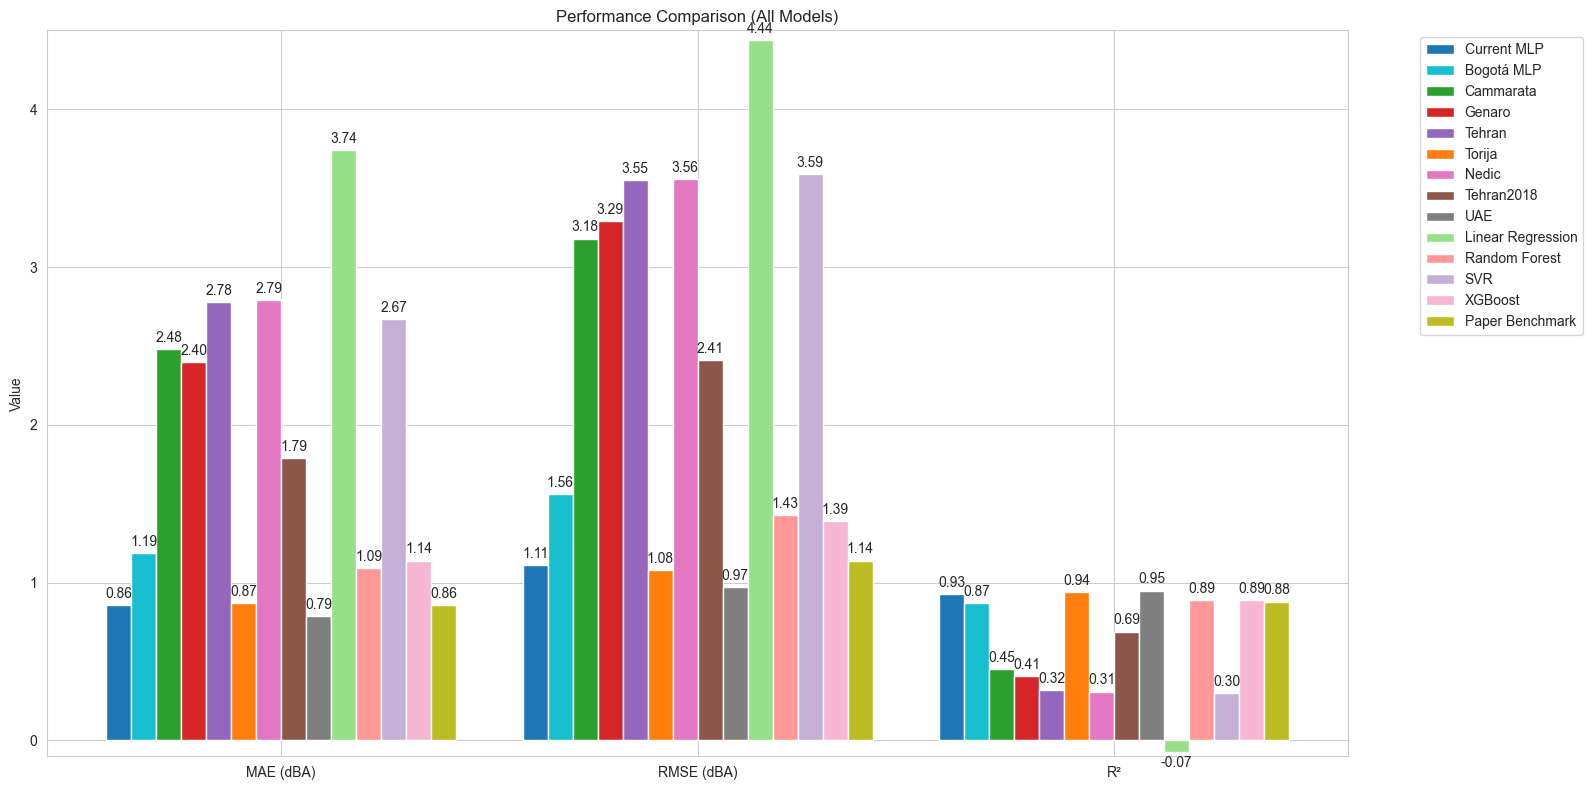

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set seaborn style for paper-like aesthetics
sns.set_style("whitegrid")

# Performance Comparison Bar Chart
metrics = ['MAE (dBA)', 'RMSE (dBA)', 'R²']
model_values = {
    'Current MLP': [0.97, 1.38, 0.90],
    'Bogotá MLP': [1.19, 1.56, 0.87],
    'Cammarata': [2.48, 3.18, 0.45],
    'Genaro': [2.40, 3.29, 0.41],
    'Tehran': [2.78, 3.55, 0.32],
    'Torija': [0.87, 1.08, 0.94],
    'Nedic': [2.79, 3.56, 0.31],
    'Tehran2018': [1.79, 2.41, 0.69],
    'UAE': [0.79, 0.97, 0.95],
    'Linear Regression': [3.74, 4.44, -0.07],
    'Random Forest': [1.09, 1.43, 0.89],
    'SVR': [2.67, 3.59, 0.30],
    'XGBoost': [1.14, 1.39, 0.89],
    'Paper Benchmark': [0.86, 1.14, 0.88]
}

x = np.arange(len(metrics))
width = 0.06  # Adjusted width for 14 models
fig, ax = plt.subplots(figsize=(16, 8))

# Colors for 14 models
colors = ['#1f77b4', '#17becf', '#2ca02c', '#d62728', '#9467bd', '#ff7f0e', 
          '#e377c2', '#8c564b', '#7f7f7f', '#98df8a', '#ff9896', '#c5b0d5', 
          '#f7b6d2', '#bcbd22']

# Plot bars
for i, (model, values) in enumerate(model_values.items()):
    offset = width * (i - len(model_values) / 2 + 0.5)
    rects = ax.bar(x + offset, values, width, label=model, color=colors[i])

ax.set_ylabel('Value')
ax.set_title('Performance Comparison (All Models)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(-0.1, 4.5)  # Set y-axis range for visibility
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')



for rects in ax.containers:
    ax.bar_label(rects, padding=3, fmt='%.2f')

plt.tight_layout()
plt.savefig('performance_comparison_plot_all.png')  # Save for report inclusion
plt.show()

In [ ]:
import datetime
from scipy.interpolate import UnivariateSpline
# Dictionary of place names to PLACE No.
place_dict = {
    'UHURU PARK': 1, 'IMAARA MALL': 2, 'KIAMBU ROAD': 3, 'LANGATA LINK ROAD': 4, 'JEVANJEE': 5,
    'KFC EMBAKASI': 6, 'RUNDA': 7, 'RAILA ODINGA ROAD NEXT TO TOTAL': 8, 'NGARA ARYA': 9,
    'KCB UTAWALA EASTERN BYPASS': 10, 'RUAKA': 11, 'NYAYO LANGATA': 12, 'OLA ENERGY WAIYAKI WAY': 13,
    'MAKONGENI SHOPPING CENTRE RUAI': 14, 'KIAMBU ROAD 2': 15, 'LIKONI ROAD': 16, 'KANGEMI': 17,
    'QUALITY MEAT PACKERS': 18, 'THOME': 19, 'WINNERS CHAPEL(LIKONI ROAD)': 20, 'KINOO': 21,
    'DAVIS & SHIRTLIFF KANGUNDO ROAD': 22, 'NORTHERN BYPASS': 23, 'LANGATA HOSPITAL': 24,
    'SOUTHERN BYPASS 1': 25, 'BEE CENTRE': 26, 'OPP. KU HOSPITAL': 27, 'MMU': 28,
    'SOUTHERN BYPASS 2': 29, 'TOTAL ENERGIES OUTERING': 30, 'NORTHERN BYPASS 2': 31,
    'KAREN C SCHOOL': 32, 'NGONG ROAD': 33, 'JOGOO ROAD': 34, 'THIKA ROAD 1': 35,
    'JUNCTION MALL': 36, 'KAWANGWARE': 37, 'BBS MALL EASTLEIGH': 38, 'THIKA ROAD 2': 39,
    'ICD ROAD': 40, 'THIKA ROAD(PANGANI)': 41, 'AROUND BABA DOGO ROAD': 42
}

# Select an example place for SPL variation plot
place_index = 0  # e.g., 0 for 'UHURU PARK'
place_name = places[place_index]
place_no = place_dict.get(place_name.upper(), place_index + 1)

# Filter data for this place (using the full dataset for consistency with test data)
place_df = df[df['place'] == place_name]
place_features = place_df[features].values
place_trues = place_df['leq'].values

# Predict for this specific place
place_scaled = scaler.transform(place_features)
place_tensor = torch.tensor(place_scaled, dtype=torch.float32).to(device)
with torch.no_grad():
    place_preds = model(place_tensor).cpu().numpy().flatten()

# Compute mean for Δ calculation (variation from mean)
mean_true = np.mean(place_trues)

# Compute deltas
delta_true = place_trues - mean_true
delta_pred = place_preds - mean_true

# Create x-axis points (0 to 11 for 12 hours)
x = np.arange(len(hours))

# Apply UnivariateSpline for smoothing
x_smooth = np.linspace(0, len(hours) - 1, 100)
spline_true = UnivariateSpline(x, delta_true, s=0.5)  # s controls smoothness
spline_pred = UnivariateSpline(x, delta_pred, s=0.5)  # s controls smoothness

# Plot the smoothed curves
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, spline_true(x_smooth), color='blue', label=f'Actual (ΔdB(A))', linewidth=2)
plt.plot(x_smooth, spline_pred(x_smooth), color='red', label=f'Predicted (ΔdB(A))', linewidth=2)
plt.xlabel('Time')
plt.ylabel('ΔdB(A)')
plt.title(f'SPL Variation Prediction for Location {place_no} (MAE: {mae:.2f}, R²: {r2:.2f})')
plt.xticks(range(len(hours)), hours, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot with a timestamp
current_time = datetime.now().strftime('%Y%m%d_%H%M%S')  # Current time: 11:13 AM EAT, September 04, 2025
filename = f'SPL_Variation_Location_{place_no}_Eval_{current_time}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

# Optional: Print raw values for debugging
print("Actual Leq for Place:", place_trues)
print("Predicted Leq for Place:", place_preds)
print("Test Predictions:", test_preds[:12])  # Show first 12 for comparison
print("Test True Values:", test_trues[:12])  # Show first 12 for comparison

TypeError: 'str' object is not callable

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

# Assume X, X_train, X_test, y_train, y_test are defined from previous cells
# If not, load and preprocess data as in your notebook (Cell 3 and 4)

# Define the MLP model based on the paper's architecture
class MLPNoisePredictor(nn.Module):
    def __init__(self, input_size=7, hidden1=25, hidden2=50):
        super(MLPNoisePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1)  # Input to first hidden layer
        self.fc2 = nn.Linear(hidden1, hidden2)     # First to second hidden layer
        self.fc3 = nn.Linear(hidden2, 1)          # Second to output layer
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on output for regression
        return x

# Initialize the model
input_size = 7  # Features: motorcycles, light, medium, heavy, speed, lanes, flow_type
model = MLPNoisePredictor(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Convert data to tensors and train the model (simplified training loop)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Compute predictions for MLP
model.eval()
with torch.no_grad():
    y_pred_mlp = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()

# Train and predict with other ML models
rf = RandomForestRegressor(n_estimators=500, max_features=3, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Simplified approximations for CoRTN and RLS-90 (as placeholders)
def cortn_approx(row):
    q = row[6]  # PCU
    V = row[4]  # speed
    P = ((row[3] + row[2]) / (row[0] + row[1] + row[2] + row[3] + 1e-6)) * 100  # % heavy + medium as heavy
    if q == 0: return 0
    L10 = 42.2 + 10 * np.log10(q) + 33 * np.log10(V / 50.0) + 10 * np.log10(1 + (5 * P) / V)
    Leq = L10 - 2  # Approximate conversion L10 to Leq
    return Leq

y_pred_cortn = np.apply_along_axis(cortn_approx, 1, X_test)



# Collect models and predictions
models = ['Current MLP', 'Bogotá MLP', 'ANN (Torija)', 'ANN (UAE)', 'XGBoost', 'SVR', 'Random Forest', 'Linear Regression', 'CoRTN', 'RLS-90']
# Use placeholders for Bogotá MLP, Torija, UAE (reusing predictions for demo)
y_pred_bogota = y_pred_mlp  # Placeholder
y_pred_torija = y_pred_rf   # Placeholder
y_pred_uae = y_pred_xgb     # Placeholder

predictions = [y_pred_mlp, y_pred_bogota, y_pred_torija, y_pred_uae, y_pred_xgb, y_pred_svr, y_pred_rf, y_pred_lr, y_pred_cortn, ]

# Load measured Leq data
df_leq = pd.read_excel('data\\FINAL DATA.xlsx', sheet_name='Noise Leq Data')
measured_leq = pd.to_numeric(df_leq.iloc[:, 2:].stack(), errors='coerce').dropna().values

# Extend predictions to match measured_leq length
calculated_leq = {}
for model_name, pred in zip(models, predictions):
    num_repeats = int(np.ceil(len(measured_leq) / len(pred)))
    extended_pred = np.tile(pred, num_repeats)[:len(measured_leq)]
    calculated_leq[model_name] = extended_pred

# Verify the result
print("Cleaned measured Leq values:", measured_leq)

# Plot Measurement vs Calculation
plt.figure(figsize=(12, 8))
plt.plot(range(len(measured_leq)), measured_leq, label='Measured Leq', color='black', alpha=0.5)
for model, calc in calculated_leq.items():
    plt.plot(range(len(calc)), calc, label=f'Calculated {model}', alpha=0.5)
plt.xlabel('Sample Index')
plt.ylabel('Leq (dBA)')
plt.title('Measurement vs Calculation Results')
plt.legend()
plt.savefig('measurement_vs_calculation.png')
plt.show()

# Bar Plot of Average Differences
avg_diff = {model: np.mean(measured_leq - calc) for model, calc in calculated_leq.items()}
plt.figure(figsize=(12, 6))
plt.bar(avg_diff.keys(), avg_diff.values())
plt.xlabel('Model')
plt.ylabel('Average Difference (Measured - Predicted, dBA)')
plt.title('Average Difference Between Measured and Predicted Leq')
plt.savefig('avg_difference_plot.png')
plt.show()

In [ ]:
# Baseline: Linear Regression on log features
X_train_log = np.log1p(df[features].iloc[:len(X_train)])  # Log transform
reg = LinearRegression().fit(X_train_log, y_train)
preds_baseline = reg.predict(np.log1p(df[features].iloc[len(X_train):]))
mae_baseline = mean_absolute_error(y_test, preds_baseline)
print(f'Baseline MAE: {mae_baseline:.2f} dBA')

# Compare: If MLP MAE < baseline, it's better

In [ ]:
torch.save(model.state_dict(), 'MLP_noise_predictor_model.pth')

In [ ]:
model.load_state_dict(torch.load('MLP_noise_predictor_model.pth'))
print(model.state_dict())

In [ ]:


# Access the state dictionary containing weights and biases
state_dict = model.state_dict()

# Extract weights and biases for each layer
W1 = state_dict['fc1.weight'].numpy()  # Shape: (25, 7)
b1 = state_dict['fc1.bias'].numpy()    # Shape: (25,)
W2 = state_dict['fc2.weight'].numpy()  # Shape: (50, 25)
b2 = state_dict['fc2.bias'].numpy()    # Shape: (50,)
W3 = state_dict['fc3.weight'].numpy()  # Shape: (1, 50)
b3 = state_dict['fc3.bias'].numpy()    # Shape: (1,)

# Print shapes to confirm
print("First Layer (fc1) Weights Shape:", W1.shape)
print("First Layer (fc1) Biases Shape:", b1.shape)
print("Second Layer (fc2) Weights Shape:", W2.shape)
print("Second Layer (fc2) Biases Shape:", b2.shape)
print("Output Layer (fc3) Weights Shape:", W3.shape)
print("Output Layer (fc3) Biases Shape:", b3.shape)

# Optionally, print the actual values (be cautious, as W2 is large: 50x25=1250 elements)
print("\nFirst Layer (fc1) Weights:\n", W1)
print("First Layer (fc1) Biases:\n", b1)
print("Second Layer (fc2) Weights:\n", W2)
print("Second Layer (fc2) Biases:\n", b2)
print("Output Layer (fc3) Weights:\n", W3)
print("Output Layer (fc3) Bias:\n", b3)

# Total parameters
total_params = sum(W1.size + b1.size + W2.size + b2.size + W3.size + b3.size)
print(f"\nTotal Parameters: {total_params}")